<a href="https://colab.research.google.com/github/Monsterp99/video-title-similarity/blob/main/YouTube_Title_Similarity_2.0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# video-title-similarity
AI-Powered Video Title Similarity &amp; Performance Analyzer
**How This Code Works**

This code was created using ChatGPT Open AI assistance. This script analyzes video titles by leveraging AI-powered natural language processing (NLP) to detect similarities and identify low-performing content. It integrates performance normalization, semantic similarity modeling, and data visualization to support content optimization.

1. **Data Preprocessing**

 - Loads a structured dataset containing video titles and key performance metrics.
 - Converts time-based metrics (e.g., "Average View Duration") into numeric values for standardization.
 - Applies MinMaxScaler to normalize performance metrics, ensuring consistent comparisons across different scales.

2. **Performance Evaluation**

 - Computes a weighted performance score based on engagement signals (views, watch time, average percentage viewed, and subscriber impact).
 - Sorts video titles from lowest to highest performance, identifying underperforming content.

3. **Semantic Similarity Analysis**

 - Uses Sentence Transformers (all-MiniLM-L6-v2) to generate vectorized embeddings of each video title.
 - Computes cosine similarity scores between all video titles, creating a semantic similarity matrix.
 - Identifies the most textually similar title for each low-performing video, helping to detect redundant content or overlapping topics.

4. **Visualization & Output**

 - Generates a heatmap to visually represent title similarity relationships.
 - Exports a structured CSV file mapping low-performing titles to their closest semantic matches for further review.

 This process streamlines content audits, topic clustering, and SEO-driven content refinements, ensuring that redundant or underperforming assets can be optimized effectively.

In [ ]:
# Install necessary dependencies
!pip install sentence-transformers matplotlib seaborn

# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sentence_transformers import SentenceTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics.pairwise import cosine_similarity

# === STEP 1: Load Data ===
# Set the file path (Modify this to your uploaded CSV file)
file_path = "ENTER FILE PATH"  # Change this to your actual file name
df = pd.read_csv(file_path)

# === STEP 2: Normalize Performance Metrics ===
performance_columns = [
    "Average percentage viewed (%)",
    "Views",
    "Watch time (hours)",
    "Average view duration",
    "Subscribers"
]

# Convert "Average view duration" from hh:mm:ss or mm:ss to seconds
def duration_to_seconds(duration):
    try:
        parts = str(duration).split(":")
        if len(parts) == 3:  # hh:mm:ss
            return int(parts[0]) * 3600 + int(parts[1]) * 60 + int(parts[2])
        elif len(parts) == 2:  # mm:ss
            return int(parts[0]) * 60 + int(parts[1])
        else:
            return float(duration)  # Already numeric
    except:
        return None  # Handle errors gracefully

df["Average view duration"] = df["Average view duration"].astype(str).apply(duration_to_seconds)

# Normalize metrics using MinMaxScaler
scaler = MinMaxScaler()
df[performance_columns] = scaler.fit_transform(df[performance_columns])

# Compute an overall performance score (weighted)
df["Performance Score"] = (
    df["Average percentage viewed (%)"] * 0.3 +
    df["Views"] * 0.2 +
    df["Watch time (hours)"] * 0.2 +
    df["Average view duration"] * 0.2 +
    df["Subscribers"] * 0.1
)

# Sort videos by performance (lowest first)
df_sorted = df.sort_values(by="Performance Score", ascending=True)

# === STEP 3: Compute Similar Titles ===
# Load Sentence Transformer model for embeddings
model = SentenceTransformer('all-MiniLM-L6-v2')

# Generate embeddings for video titles
df["Title Embedding"] = df["Video title"].apply(lambda x: model.encode(str(x)))

# Convert embeddings to a NumPy array
embeddings = np.vstack(df["Title Embedding"].values)

# Compute cosine similarity between all video titles
similarity_matrix = cosine_similarity(embeddings)

# Convert to DataFrame for easier analysis
similarity_df = pd.DataFrame(similarity_matrix, index=df["Video title"], columns=df["Video title"])

# === STEP 4: Generate & Save the Similarity Heatmap ===
plt.figure(figsize=(12, 10))
sns.heatmap(similarity_df, cmap="coolwarm", annot=False)
plt.title("Video Title Similarity Matrix")
plt.show()

# === STEP 5: Identify Similar Titles & Save CSV ===
low_performers = df_sorted.head(10).copy()  # Select the lowest-performing videos

# Initialize a list to store similar titles
similar_titles = []

# Loop through each low-performing title
for index, row in low_performers.iterrows():
    title = row["Video title"]
    title_embedding = model.encode(title)

    # Compute similarity scores with all other titles
    similarities = cosine_similarity([title_embedding], embeddings)[0]

    # Get the most similar title (excluding itself)
    sorted_indices = np.argsort(similarities)[::-1]

    found_match = False
    for i in sorted_indices:
        if i != index:  # Skip itself
            similar_title = df.iloc[i]["Video title"]
            similar_titles.append(similar_title)
            found_match = True
            break

    # If no match is found, mark it
    if not found_match:
        similar_titles.append("No Similar Title Found")

# Add similar titles to the DataFrame
low_performers["Similar Title"] = similar_titles

# Save to CSV for reference
low_performers.to_csv("low_performing_titles_with_similar.csv", index=False)
print("CSV file saved: low_performing_titles_with_similar.csv")

# Display the table in Colab
from IPython.display import display
display(low_performers)

In [5]:
# =========================
# 1) Install + Imports
# =========================
!pip install -q gspread gspread_dataframe sentence-transformers scikit-learn pandas numpy

import re
import pandas as pd
import numpy as np

import gspread
from google.colab import auth
from google.auth import default
from gspread_dataframe import get_as_dataframe, set_with_dataframe

from sentence_transformers import SentenceTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics.pairwise import cosine_similarity


# =========================
# 2) USER CONFIG (EDIT ME)
# =========================
# Google Sheet settings
SHEET_NAME = "Organic Content Last 90 Days (10.27)"   # <-- Your Google Sheet name
WORKSHEET_TITLE = None                                 # e.g., "Data"; leave None to use first tab
OUTPUT_SHEET_TITLE = "Similarity Output"

# Required column names in your Sheet (change if different)
VIDEO_ID_COL = "Video ID"         # if missing, an ID will be created
TITLE_COL    = "Video title"
DATE_COL     = "Date"             # optional; only used if DATE_MIN is set

# Metrics available in your sheet (raw). We'll keep these in final output.
VIEWS_COL    = "Views"
LIKES_COL    = "Likes"
DURATION_SEC_COL = "Duration (sec)"   # You said you'll manage/fix seconds upstream

# Performance columns to normalize (used only for score; originals preserved)
# You asked to omit "Average view duration" from OUTPUT, not from scoring—keeping it here is OK.
PERF_COLS = [
    "Average percentage viewed (%)",
    "Views",
    "Watch time (hours)",
    "Average view duration",  # may be mm:ss/hh:mm:ss or numeric; we coerce safely
    "Likes"
]

# Weights for Performance Score (sum ~ 1.0)
WEIGHTS = {
    "Average percentage viewed (%)": 0.30,
    "Views":                         0.25,
    "Watch time (hours)":            0.20,
    "Average view duration":         0.15,
    "Likes":                         0.10
}

# Similarity & grouping
GROUP_MIN_SIM = 0.60     # tighten/loosen grouping (0.45–0.70 typical)
MIN_GROUP_SIZE = 1       # hide groups smaller than this if desired (1 = keep singletons)

# Similarity score column
INCLUDE_SIMILARITY_SCORE = True
SIMILARITY_MODE = "max"  # "max" (top match inside group) or "mean" (avg vs group)

# Manual category presets (you fill these)
# Example:
# CATEGORIES_PRESET = {
#   "Commencement": ["commencement","graduation","ceremony","convocation"],
#   "Admissions":   ["admissions","apply","deadline","requirements","application"],
# }
CATEGORIES_PRESET = {
    "Ceremonies & Milestones": [
        "white coat ceremony", "white coat", "commencement", "graduation",
        "match day", "match madness", "matching", "matched", "celebration of academic",
        "academic excellence", "convocation", "grads", "graduates"
    ],

    "Student Experience & Community": [
        "student life", "day in the life", "testimonial", "my journey",
        "community day", "community action", "campus tour", "virtual tour",
        "student stories", "alumni", "meet an auc", "housing", "residence life",
        "sint maarten", "caribbean", "island", "uk track", "canadian"
    ],

    "Academic Program & Enrollment": [
        "start date", "january start", "may start", "september start",
        "become an md", "start your journey", "medical school", "school of medicine",
        "admissions", "application", "clinical", "residency", "merp", "why choose",
        "auc advantage", "both right", "aucmed"
    ]
}

# Category assignment behavior
CATEGORY_STRICT_MODE = True  # Only assign a category on a row if title matches its keywords
MAX_CATEGORY_SUGGESTIONS = 3 # We output up to 3 category columns

# Optional: limit data by date (set to None to disable)
DATE_MIN = None  # e.g., "2025-01-01"


# =========================
# 3) Auth + Load Google Sheet → DataFrame
# =========================
auth.authenticate_user()
creds, _ = default()
gc = gspread.authorize(creds)

sh = gc.open(SHEET_NAME)
ws = sh.worksheet(WORKSHEET_TITLE) if WORKSHEET_TITLE else sh.sheet1

df = get_as_dataframe(ws, evaluate_formulas=True, header=0)
df = df.dropna(how="all").copy()
df = df.loc[:, ~df.columns.duplicated()].copy()

if TITLE_COL not in df.columns:
    raise ValueError(f"Missing required column: '{TITLE_COL}'")

if VIDEO_ID_COL not in df.columns:
    df[VIDEO_ID_COL] = np.arange(len(df))

if DATE_MIN is not None and DATE_COL in df.columns:
    df[DATE_COL] = pd.to_datetime(df[DATE_COL], errors="coerce")
    df = df[df[DATE_COL] >= pd.to_datetime(DATE_MIN)].copy()

print(f"Loaded {len(df)} rows from '{SHEET_NAME}'" + (f" / '{WORKSHEET_TITLE}'" if WORKSHEET_TITLE else ""))
display(df.head(3))


# =========================
# 4) Helpers
# =========================
def duration_to_seconds(val):
    """Convert 'hh:mm:ss' or 'mm:ss' to seconds, pass numeric through, NaN on failure."""
    try:
        s = str(val)
        if s.count(":") == 2:
            h,m,ss = s.split(":"); return int(h)*3600 + int(m)*60 + int(ss)
        if s.count(":") == 1:
            m,ss = s.split(":");   return int(m)*60 + int(ss)
        return float(s)
    except:
        return np.nan

def to_numeric_series(s):
    return pd.to_numeric(s, errors="coerce").fillna(0.0)

def compute_performance_score(df, perf_cols, weights):
    """Compute score using scaled copies; preserve raw columns."""
    # Coerce to numeric; convert duration-like text if necessary
    safe = pd.DataFrame(index=df.index)
    for c in perf_cols:
        if c in df.columns:
            col = df[c]
            # special-case: try to parse time if it looks like "mm:ss"
            as_num = pd.to_numeric(col, errors="coerce")
            if as_num.isna().all():
                # try time parsing
                as_num = col.astype(str).apply(duration_to_seconds)
            safe[c] = to_numeric_series(as_num)
        else:
            safe[c] = 0.0

    scaler = MinMaxScaler()
    scaled_vals = scaler.fit_transform(safe[perf_cols].values)
    scaled_cols = [f"{c} (scaled)" for c in perf_cols]
    df[scaled_cols] = scaled_vals

    score = 0.0
    for c in perf_cols:
        w = float(weights.get(c, 0.0))
        score = score + df[f"{c} (scaled)"] * w
    df["Performance Score"] = score
    return df

def build_groups(sim_mat, min_sim=0.60):
    """Connected components based on sim >= min_sim."""
    n = sim_mat.shape[0]
    visited = [False]*n
    groups = []
    for i in range(n):
        if visited[i]:
            continue
        stack = [i]; visited[i] = True
        comp = []
        while stack:
            u = stack.pop()
            comp.append(u)
            for v in range(n):
                if not visited[v] and sim_mat[u, v] >= min_sim:
                    visited[v] = True
                    stack.append(v)
        groups.append(sorted(comp))
    return [g for g in groups if len(g) >= MIN_GROUP_SIZE]

def title_matches_category(title, category_name, presets):
    """True if this title matches the category's keyword list (word-boundary)."""
    t = str(title).lower()
    if presets and category_name in presets:
        keys = presets[category_name]
        if not keys: return False
        pat = r'\b(?:' + '|'.join([re.escape(k.lower()) for k in keys]) + r')\b'
        return re.search(pat, t) is not None
    # If no presets, we don't auto-fill category names here.
    return False

def filter_cats_for_title(title, cats, presets, max_out=3, strict=True):
    if not cats: return [""]*max_out
    if strict:
        kept = [c for c in cats if c and title_matches_category(title, c, presets)]
    else:
        kept = [c for c in cats if c]  # keep group labels regardless of row match
    while len(kept) < max_out: kept.append("")
    return kept[:max_out]


# =========================
# 5) Performance Score
# =========================
df = compute_performance_score(df, PERF_COLS, WEIGHTS)


# =========================
# 6) Title Embeddings + Similarity Matrix + Groups
# =========================
model = SentenceTransformer("all-MiniLM-L6-v2")
titles = df[TITLE_COL].fillna("").astype(str).tolist()
embeddings = model.encode(titles, normalize_embeddings=True)
sim_mat = cosine_similarity(embeddings)

groups = build_groups(sim_mat, min_sim=GROUP_MIN_SIM)
print(f"Discovered {len(groups)} group(s) @ threshold {GROUP_MIN_SIM}.")


# =========================
# 7) Prepare per-row fields: Group ID, Similarity Score, Categories
# =========================
# Map each row -> group id
row_to_group = {i: -1 for i in range(len(df))}
for gid, comp in enumerate(groups):
    for idx in comp:
        row_to_group[idx] = gid

# Compute Similarity Score per row (within its group)
sim_scores = np.zeros(len(df), dtype=float)
if INCLUDE_SIMILARITY_SCORE:
    for gid, comp in enumerate(groups):
        if len(comp) == 1:
            sim_scores[comp[0]] = 0.0
            continue
        sub = sim_mat[np.ix_(comp, comp)]
        # zero diagonal (self)
        np.fill_diagonal(sub, 0.0)
        if SIMILARITY_MODE == "mean":
            vals = sub.sum(axis=1) / (sub.shape[1] - 1)
        else:  # "max"
            vals = sub.max(axis=1)
        for local_i, row_i in enumerate(comp):
            sim_scores[row_i] = float(vals[local_i])

# Group-level categories come from your preset keys only (no auto labels)
# We just keep the list of category names you defined; row-level strict filter decides visibility.
group_cats = {}
if CATEGORIES_PRESET:
    preset_names = list(CATEGORIES_PRESET.keys())
    # Simply take up to first 3 category names that are well represented in the group (by keyword hits)
    for gid, comp in enumerate(groups):
        titles_in_group = [titles[i] for i in comp]
        # Score each preset by count of titles matching any of its keywords
        scored = []
        for cat in preset_names:
            keys = CATEGORIES_PRESET.get(cat, [])
            if not keys:
                scored.append((cat, 0))
                continue
            pat = r'\b(?:' + '|'.join([re.escape(k.lower()) for k in keys]) + r')\b'
            cnt = sum(1 for t in titles_in_group if re.search(pat, t.lower()))
            scored.append((cat, cnt))
        # pick the top ones with cnt>0
        scored.sort(key=lambda x: (-x[1], x[0]))
        picked = [c for c, cnt in scored if cnt > 0][:MAX_CATEGORY_SUGGESTIONS]
        # pad to length
        while len(picked) < MAX_CATEGORY_SUGGESTIONS: picked.append("")
        group_cats[gid] = picked
else:
    # No presets—leave group categories blank; rows will remain blank as well.
    for gid, _ in enumerate(groups):
        group_cats[gid] = ["", "", ""]


# =========================
# 8) Build final output (only the columns you want)
# =========================
def safe_get(row, col_name, default=""):
    return row.get(col_name, default)

# Prepare metric series (raw, not scaled)
views_ser  = to_numeric_series(df.get(VIEWS_COL, pd.Series([0]*len(df))))
likes_ser  = to_numeric_series(df.get(LIKES_COL, pd.Series([0]*len(df))))
dur_ser    = pd.to_numeric(df.get(DURATION_SEC_COL, pd.Series([np.nan]*len(df))), errors="coerce")

rows_out = []
for i in range(len(df)):
    gid = row_to_group.get(i, -1)
    base_cats = group_cats.get(gid, ["","",""])
    # Apply per-row strict match if enabled
    cats = filter_cats_for_title(df.iloc[i].get(TITLE_COL, ""), base_cats, CATEGORIES_PRESET,
                                 max_out=MAX_CATEGORY_SUGGESTIONS, strict=CATEGORY_STRICT_MODE)

    out = {
        "Group ID": gid,
        "Category Group": cats[0],
        "2nd Category Group": cats[1],
        "3rd Category Group": cats[2],
        "Video ID": df.iloc[i].get(VIDEO_ID_COL, ""),
        "Video title": df.iloc[i].get(TITLE_COL, ""),
        "Performance Score": round(float(df.iloc[i].get("Performance Score", 0.0)), 4),
        "Views": float(views_ser.iloc[i]) if len(views_ser) else "",
        "Likes": float(likes_ser.iloc[i]) if len(likes_ser) else "",
        "Duration (sec)": float(dur_ser.iloc[i]) if len(dur_ser) else ""
    }
    if INCLUDE_SIMILARITY_SCORE:
        out["Similarity Score"] = round(float(sim_scores[i]), 4)
    rows_out.append(out)

# Order columns exactly as requested
ordered_cols = [
    "Group ID", "Category Group", "2nd Category Group", "3rd Category Group",
    "Video ID", "Video title", "Performance Score"
]
if INCLUDE_SIMILARITY_SCORE:
    ordered_cols.append("Similarity Score")
ordered_cols += ["Views", "Likes", "Duration (sec)"]

similarity_output = pd.DataFrame(rows_out)[ordered_cols]

# Sort by group, then by Performance Score desc
similarity_output.sort_values(by=["Group ID","Performance Score"], ascending=[True, False], inplace=True)
similarity_output.reset_index(drop=True, inplace=True)

# Save CSV
similarity_output.to_csv("similarity_output.csv", index=False)
print("Saved → similarity_output.csv")
display(similarity_output.head(20))


# =========================
# 9) Write back to Google Sheet (new/cleared tab)
# =========================
try:
    try:
        out_ws = sh.worksheet(OUTPUT_SHEET_TITLE)
        out_ws.clear()
    except gspread.exceptions.WorksheetNotFound:
        out_ws = sh.add_worksheet(title=OUTPUT_SHEET_TITLE,
                                  rows=str(max(1000, len(similarity_output)+10)),
                                  cols=str(len(similarity_output.columns)+5))
    set_with_dataframe(out_ws, similarity_output, include_index=False, include_column_header=True, resize=True)
    print(f"Wrote results to Sheet → '{SHEET_NAME}' / '{OUTPUT_SHEET_TITLE}'")
except Exception as e:
    print("Could not write back to Google Sheet (continuing):", e)

Loaded 361 rows from 'Organic Content Last 90 Days (10.27)'


,Video ID,Url,Video title,Video publish time,Duration,Duration (HMS),Average percentage viewed (%),Views,Watch time (hours),Average view duration,Likes
0,Poj_0e3fRow,https://www.youtube.com/watch?v=Poj_0e3fRow,AUC 15 Match Day Paid Assets Design Request,NaN,16.0,0:00:16,84.92,2992.0,11.2918,0:00:13,-2.0
1,hhgmZh04AYM,https://www.youtube.com/watch?v=hhgmZh04AYM,The end result will be worth all of the hard w...,"Oct 9, 2025",19.0,0:00:19,58.71,2052.0,2.3584,0:00:11,16.0
2,m2b3vt-hvFo,https://www.youtube.com/watch?v=m2b3vt-hvFo,Congrats to our 2025 #AUC graduates! #aucmed #...,"Aug 27, 2025",49.0,0:00:49,36.49,1665.0,3.6615,0:00:17,18.0


Discovered 51 group(s) @ threshold 0.6.
Saved → similarity_output.csv


,Group ID,Category Group,2nd Category Group,3rd Category Group,Video ID,Video title,Performance Score,Similarity Score,Views,Likes,Duration (sec)
0,0,Ceremonies & Milestones,,,Poj_0e3fRow,AUC 15 Match Day Paid Assets Design Request,0.2968,0.9739,2992.0,-2.0,NaN
1,0,Ceremonies & Milestones,,,HMRRu00ekT0,AUC 6 V2 Match Day Paid Assets Design Request,0.0217,0.9801,28.0,1.0,NaN
2,0,Ceremonies & Milestones,,,LtOmMDqf1sc,REC AUC 60 Match Day Paid Assets Design Request,0.0167,0.9531,1.0,0.0,NaN
3,0,Ceremonies & Milestones,,,r9MJka9pPd4,AUC 30 Match Day Paid Assets Design Request,0.0159,0.9649,17.0,0.0,NaN
4,0,Ceremonies & Milestones,,,LfRik8Ix46c,AUC 6 Match Day Paid Assets Design Request,0.0158,0.9801,20.0,0.0,NaN
5,0,Ceremonies & Milestones,,,K7P52luo4Ok,AUC 15 V2 Match Day Paid Assets Design Request,0.0157,0.9739,13.0,0.0,NaN
6,1,Academic Program & Enrollment,,,KQa7WoGo4VY,AUC Both Right Doctor Ending 9x16 30,0.3826,0.7642,8.0,0.0,NaN
7,1,Ceremonies & Milestones,Student Experience & Community,,WlfFO7UvFWk,AUC Fall 2025 White Coat Ceremony - UK Track,0.2788,0.9552,432.0,1.0,NaN
8,1,Academic Program & Enrollment,,,hhgmZh04AYM,The end result will be worth all of the hard w...,0.2632,0.8056,2052.0,16.0,NaN
9,1,Student Experience & Community,,,0tCmnqplAdw,AUC UW Community Day,0.2446,0.8892,1485.0,21.0,NaN


Wrote results to Sheet → 'Organic Content Last 90 Days (10.27)' / 'Similarity Output'


Loaded 361 rows for visuals.


,Group ID,Category Group,2nd Category Group,3rd Category Group,Video ID,Video title,Performance Score,Similarity Score,Views,Likes,Duration (sec)
0,0,Ceremonies & Milestones,NaN,NaN,Poj_0e3fRow,AUC 15 Match Day Paid Assets Design Request,0.2968,0.9739,2992.0,-2.0,NaN
1,0,Ceremonies & Milestones,NaN,NaN,HMRRu00ekT0,AUC 6 V2 Match Day Paid Assets Design Request,0.0217,0.9801,28.0,1.0,NaN
2,0,Ceremonies & Milestones,NaN,NaN,LtOmMDqf1sc,REC AUC 60 Match Day Paid Assets Design Request,0.0167,0.9531,1.0,0.0,NaN


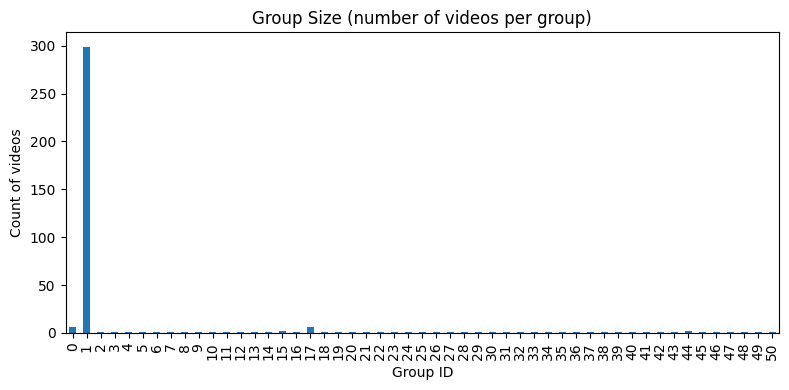

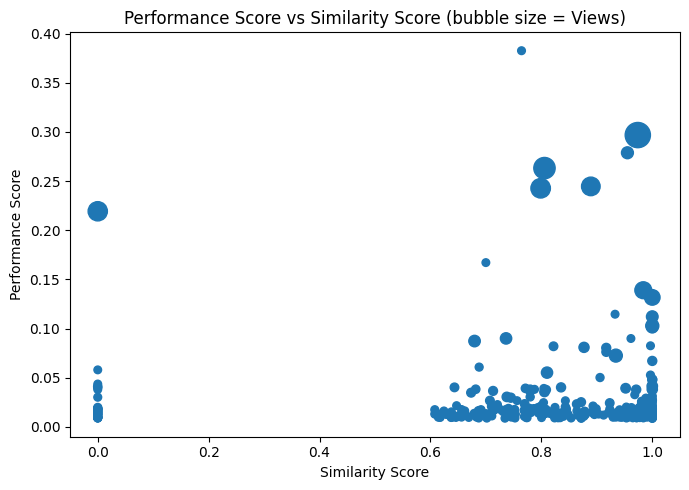

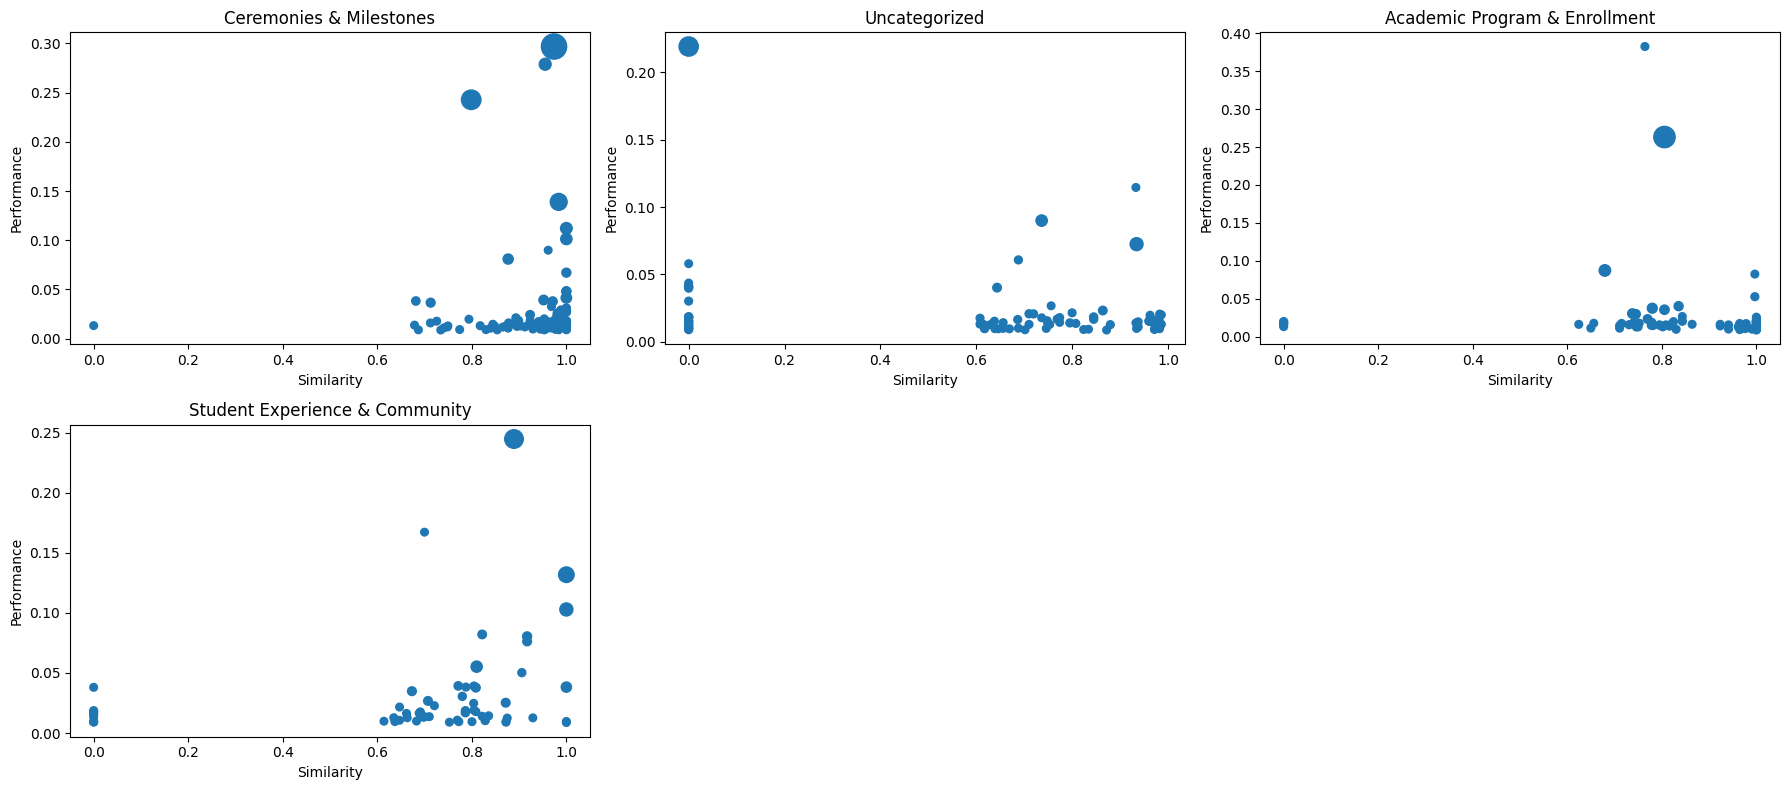

/tmp/ipython-input-1629204735.py:165: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=keep_cats, showfliers=False)


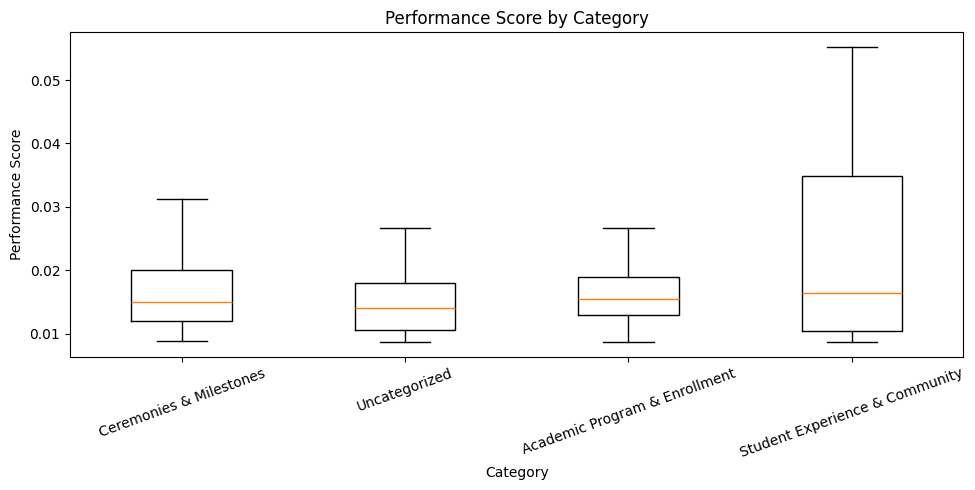

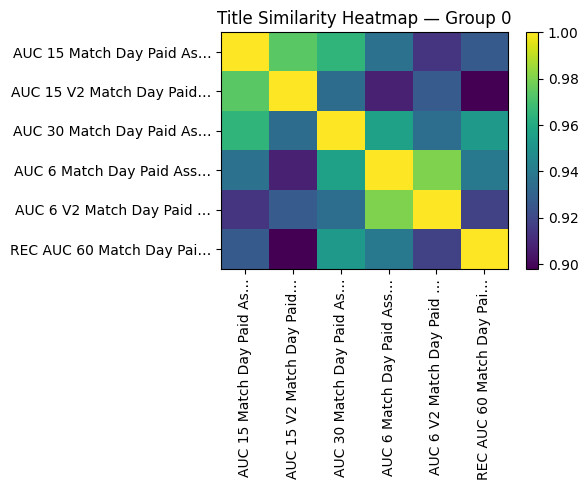

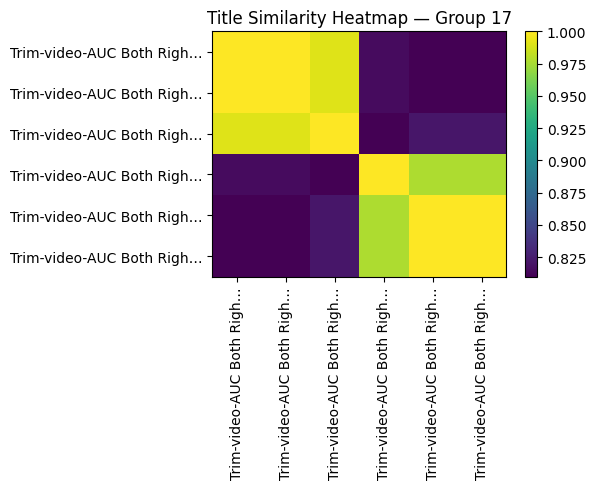

In [6]:
# =========================
# 0) Install + Imports
# =========================
!pip install -q gspread gspread_dataframe sentence-transformers pandas numpy scikit-learn

import os
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Optional: for loading directly from Google Sheets
import gspread
from google.colab import auth
from google.auth import default
from gspread_dataframe import get_as_dataframe

# Optional: for heatmaps (recompute embeddings quickly from titles)
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity


# =========================
# 1) CONFIG — choose where to load your finished output
# =========================
SOURCE_MODE = "csv"   # "csv" or "sheet"

# If SOURCE_MODE == "csv"
CSV_PATH = "/content/similarity_output.csv"  # or wherever you saved it

# If SOURCE_MODE == "sheet"
SHEET_NAME = "Organic Content Last 90 Days (10.27)"
OUTPUT_SHEET_TITLE = "Similarity Output"

# Heatmap controls (set to 0 to disable heatmaps)
PLOT_HEATMAPS = 1
HEATMAP_MAX_GROUP_SIZE = 30   # skip heatmaps for larger groups
HEATMAP_TOP_GROUPS = 3        # only visualize up to X groups (by size)

# Safe defaults for columns (match your main script output)
COL_GROUP     = "Group ID"
COL_CAT1      = "Category Group"
COL_CAT2      = "2nd Category Group"
COL_CAT3      = "3rd Category Group"
COL_ID        = "Video ID"
COL_TITLE     = "Video title"
COL_SCORE     = "Performance Score"
COL_SIM       = "Similarity Score"   # ensure your main script includes this
COL_VIEWS     = "Views"
COL_LIKES     = "Likes"
COL_DUR       = "Duration (sec)"


# =========================
# 2) Load data
# =========================
if SOURCE_MODE == "csv":
    assert os.path.exists(CSV_PATH), f"CSV not found: {CSV_PATH}"
    df = pd.read_csv(CSV_PATH)
else:
    auth.authenticate_user()
    creds, _ = default()
    gc = gspread.authorize(creds)
    sh = gc.open(SHEET_NAME)
    ws = sh.worksheet(OUTPUT_SHEET_TITLE)
    df = get_as_dataframe(ws, evaluate_formulas=True, header=0).dropna(how="all")

# Ensure types
for num_col in [COL_SCORE, COL_SIM, COL_VIEWS, COL_LIKES, COL_DUR]:
    if num_col in df.columns:
        df[num_col] = pd.to_numeric(df[num_col], errors="coerce")

# Minimal clean
df = df.loc[:, ~df.columns.duplicated()].copy()
df = df.dropna(subset=[COL_TITLE])  # must have titles for visuals

print(f"Loaded {len(df)} rows for visuals.")
display(df.head(3))


# =========================
# 3) Helper: safe category label (prefers Category Group, falls back to 2nd/3rd)
# =========================
def first_nonblank(*vals):
    for v in vals:
        if isinstance(v, str) and v.strip():
            return v.strip()
    return "Uncategorized"

df["_CategoryDisplay"] = df.apply(
    lambda r: first_nonblank(r.get(COL_CAT1, ""), r.get(COL_CAT2, ""), r.get(COL_CAT3, "")),
    axis=1
)

# Some charts work better if we fill missing Similarity Score with 0
if COL_SIM in df.columns and df[COL_SIM].isna().any():
    df[COL_SIM] = df[COL_SIM].fillna(0.0)


# =========================
# 4) Chart A: Group size bar chart
# =========================
if COL_GROUP in df.columns:
    group_sizes = df[COL_GROUP].value_counts().sort_index()
    plt.figure(figsize=(8, 4))
    group_sizes.plot(kind="bar")
    plt.title("Group Size (number of videos per group)")
    plt.xlabel("Group ID")
    plt.ylabel("Count of videos")
    plt.tight_layout()
    plt.show()


# =========================
# 5) Chart B: Scatter — Performance vs Similarity (bubble size by Views)
# =========================
if COL_SIM in df.columns:
    # Normalize bubble sizes for readability
    views = df[COL_VIEWS].fillna(0)
    if views.max() > 0:
        sizes = 300 * (views / views.max()) + 30  # minimum bubble size
    else:
        sizes = pd.Series([50]*len(df))

    # One big scatter
    plt.figure(figsize=(7, 5))
    plt.scatter(df[COL_SIM], df[COL_SCORE], s=sizes)
    plt.title("Performance Score vs Similarity Score (bubble size = Views)")
    plt.xlabel("Similarity Score")
    plt.ylabel("Performance Score")
    plt.tight_layout()
    plt.show()

    # Faceted by category (small multiples)
    cats = df["_CategoryDisplay"].value_counts().index.tolist()[:6]  # top 6 cats
    n = len(cats)
    if n > 0:
        cols = 3
        rows = math.ceil(n / cols)
        fig = plt.figure(figsize=(6*cols, 4*rows))
        for i, cat in enumerate(cats, start=1):
            ax = fig.add_subplot(rows, cols, i)
            sub = df[df["_CategoryDisplay"] == cat]
            sub_sizes = 300 * (sub[COL_VIEWS].fillna(0) / views.max()) + 30 if views.max() > 0 else 50
            ax.scatter(sub[COL_SIM], sub[COL_SCORE], s=sub_sizes)
            ax.set_title(cat)
            ax.set_xlabel("Similarity")
            ax.set_ylabel("Performance")
        plt.tight_layout()
        plt.show()


# =========================
# 6) Chart C: Boxplot — Performance Score by Category
# =========================
# Keep categories with enough rows
cat_counts = df["_CategoryDisplay"].value_counts()
keep_cats = cat_counts[cat_counts >= 3].index.tolist()  # require 3+ samples for stability
sub_bp = df[df["_CategoryDisplay"].isin(keep_cats)]

if len(sub_bp) >= 3:
    # build boxplot data
    data = [sub_bp[sub_bp["_CategoryDisplay"] == c][COL_SCORE].dropna().values for c in keep_cats]
    plt.figure(figsize=(10, 5))
    plt.boxplot(data, labels=keep_cats, showfliers=False)
    plt.title("Performance Score by Category")
    plt.xlabel("Category")
    plt.ylabel("Performance Score")
    plt.xticks(rotation=20)
    plt.tight_layout()
    plt.show()


# =========================
# 7) Chart D (Optional): Per-group similarity heatmaps
# =========================
if PLOT_HEATMAPS and COL_GROUP in df.columns:
    # Recompute quick embeddings from titles in the SIMILARITY OUTPUT
    model = SentenceTransformer("all-MiniLM-L6-v2")
    titles = df[COL_TITLE].fillna("").astype(str).tolist()
    embeds = model.encode(titles, normalize_embeddings=True)

    # Choose top groups by size
    group_sizes = df[COL_GROUP].value_counts().sort_values(ascending=False)
    top_groups = group_sizes.head(HEATMAP_TOP_GROUPS).index.tolist()

    for gid in top_groups:
        members = df.index[df[COL_GROUP] == gid].tolist()
        if len(members) < 2 or len(members) > HEATMAP_MAX_GROUP_SIZE:
            continue
        sub = embeds[members, :]
        sm = cosine_similarity(sub)

        # Sort within group by title for stable display
        order = np.argsort([titles[i].lower() for i in members])
        sm = sm[np.ix_(order, order)]
        labels = [titles[members[i]] for i in order]

        plt.figure(figsize=(max(6, len(members)*0.25), max(5, len(members)*0.25)))
        plt.imshow(sm, aspect="auto")
        plt.colorbar()
        plt.title(f"Title Similarity Heatmap — Group {gid}")
        plt.xticks(range(len(labels)), [l[:24] + ("…" if len(l) > 24 else "") for l in labels], rotation=90)
        plt.yticks(range(len(labels)), [l[:24] + ("…" if len(l) > 24 else "") for l in labels])
        plt.tight_layout()
        plt.show()
